In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Dropout, Attention, Flatten, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import shap

### UTILITY FUNCTIONS

In [2]:
### IBWC file reader
def clean_IBWC_csvs(path,dropcols='End of Interval (UTC-06:00)',value_current="Average (TCM)",
                    value_target="storage",datecol="Start of Interval (UTC-06:00)",start_date='1962-01-01',end_date='2023-12-31'):
    """
    Cleans a csv dataset from the IBWC
    """
    dat = pd.read_csv(path,skiprows=4,skipfooter=1,engine='python')
    try:
        dat.drop(dropcols, inplace=True, axis='columns')
    except:
        print(f'No columns to drop, continuing...')
    dat[datecol] = pd.to_datetime(dat[datecol])
    dat.rename(columns={datecol:"date", value_current:value_target}, inplace=True)
    dat["date"] = pd.to_datetime(dat["date"])
    dat = dat[(dat['date'] >= start_date) & (dat['date'] <= end_date)]
    return dat


In [3]:
def process_data(df, lookback_period=100, lag=3, debug=0, trainyrs=5, valyrs=3):
    if debug:
        print("Initial Data:")
        print(df.head())

    data = df.copy()

    # Ensure the date column is datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Add lagged features dynamically based on the specified lag
    for i in range(1, lag + 1):
        data[f'flow_lag{i}'] = data['flow'].shift(i)
        data[f'total_lag{i}'] = data['total'].shift(i)
        data[f'storage_lag{i}'] = data['storage'].shift(i)
    
    if debug:
        print("\nData with Lagged Features:")
        print(data.head(lag + 2))  # Display more rows to show the lagged features

    # Drop rows with NaN values due to lagging
    data = data.dropna()
    
    if debug:
        print("\nData after Dropping NaN Values:")
        print(data.head())

    # Select features
    feature_columns = [f'flow_lag{i}' for i in range(1, lag + 1)] + \
                      ['total'] + [f'total_lag{i}' for i in range(1, lag + 1)] + \
                      ['storage'] + [f'storage_lag{i}' for i in range(1, lag + 1)]
    
    if debug:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    features = data[feature_columns]
    target = data['flow']

    if debug:
        print("\nFeatures DataFrame:")
        print(features.head())
        
        print("\nTarget Series:")
        print(target.head())

    # Perform Z-score normalization using numpy
    feature_means = features.mean(axis=0)
    feature_stds = features.std(axis=0)
    features_scaled = (features - feature_means) / feature_stds

    target_mean = target.mean()
    target_std = target.std()
    target_scaled = (target - target_mean) / target_std

    if debug:
        print("\nNormalized Features DataFrame:")
        print(features_scaled.head())
        
        print("\nNormalized Target Series:")
        print(target_scaled.head())

    # Convert to numpy arrays
    features_scaled = features_scaled.values
    target_scaled = target_scaled.values

    X = []
    y = []

    for i in range(lookback_period, len(features_scaled)):
        X.append(features_scaled[i-lookback_period:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25*trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25*valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1] - lookback_period + 1
    val_end_index = data[data['date'] <= val_end_date].index[-1] - lookback_period + 1

    X_train, X_val, X_test = X[:train_end_index], X[train_end_index:val_end_index], X[val_end_index:]
    y_train, y_val, y_test = y[:train_end_index], y[train_end_index:val_end_index], y[val_end_index:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'].iloc[:train_end_index + lookback_period]
    val_dates = data['date'].iloc[train_end_index + lookback_period:val_end_index + lookback_period]
    test_dates = data['date'].iloc[val_end_index + lookback_period:]

    # Denorm dictionary for inverse transformation of predictions
    denorm_dict = {
        'feature_means': feature_means,
        'feature_stds': feature_stds,
        'target_mean': target_mean,
        'target_std': target_std,
    }

    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug:
        print("\nFirst 5 rows of Training Data (X_train):")
        print(X_train[:5])
        print("\nFirst 5 rows of Training Targets (y_train):")
        print(y_train[:5])
        
        print("\nDenormalization Dictionary:")
        print(denorm_dict)

        print("\nTraining Date Range:")
        print(train_dates.iloc[0], "to", train_dates.iloc[-1])

        print("\nValidation Date Range:")
        print(val_dates.iloc[0], "to", val_dates.iloc[-1])

        print("\nTest Date Range:")
        print(test_dates.iloc[0], "to", test_dates.iloc[-1])

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_columns

## Phase 1 - Understanding Deliveries in the Rio Grande
#### Goals
* show the historical trajectory of deliveries
* show the response to rainfall
* understand the correlation to runoff
* (explore the 1992 regime shift wrt to precipitation in the historical record)
#### Figures
1. Cumulative deliveries from IBWC
2. Flow at each tributary from IBWC
3. Total precipitation vs reservoir level

In [2]:
### IMPORT ALL DATA ###
# 1. reservoirs
# 2. streamflow & deliveries
# 3. basin total precipitation
# 4. tropical cyclone tracks
# 5. tropical cyclone precipitation

In [4]:
subbasins = gpd.read_file("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/RGB_subbasins/RGB_subbasins.shp")

<Axes: >

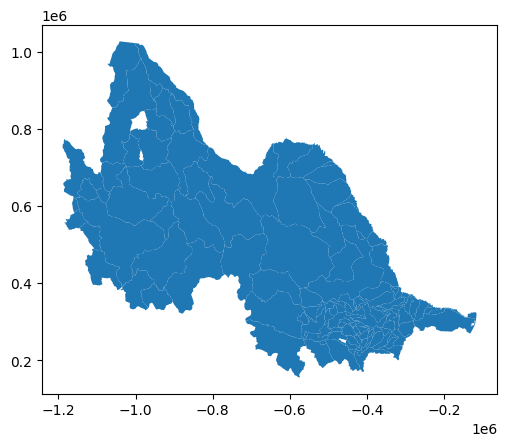

In [61]:
subbasins.plot()

### 1. Exploratory analysis 
Section to visualize the timeseries and relationships between these variables

### 2. Feature Selection
Section to perform feature selection, analysing the relationships, autocorrelation and parameters that could be fed to the LSTM.

## Phase 2 - LSTM Prediction
#### Goals
* build a model to predict streamflow at each tributary, using some combination of the following variables
    1. Basin total precipitation
    2. Tropical cyclone precipitation
    3. Sub-basin precipitation
    4. Reservoir levels
    5. Static conservation pool for each reservoir
    6. ERA5 average surface temperature in subbasin (?)
    7. Daymet average temperature at reservoirs

## Testing on the Conchos
The following section is a test of the model for the Rio Conchos, using La Boquilla as our upstream reservoir that the model is trying to learn. We first conduct an extremely simple test with no TCs and the basic parameters and model set up.
### 1. No awareness of TCs or subbasins
* Training the LSTM model to predict the flow at each tributary

In [5]:
#### IMPORTING DATA FOR THE CONCHOS ####
# Conchos streamflow
conchos_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/conchos_discharge.csv",
                              value_current="Average (m^3/d)",value_target="flow",start_date='2000-06-01',end_date='2019-12-31')
# La Boquilla storage
laboq_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/la_boquilla_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="storage",start_date='2000-06-01',end_date='2019-12-31')
# Conchos daymet
# Basin precip
rgb_precip = pd.read_csv("/Users/laratobias-tarsh/Documents/SEAS_hydro/mexico_basin_totals.csv")
rgb_precip_total = rgb_precip.drop(['idx','non_tc','tc'],axis='columns')
rgb_precip_total['date'] = pd.to_datetime(rgb_precip_total['date'])

No columns to drop, continuing...


#### Prepare the data for machine learning

In [6]:
##### CONCAT DATA #####
merged_df = pd.merge(conchos_dis, rgb_precip_total, on='date')
ml_data = pd.merge(merged_df, laboq_stor, on='date')
ml_data.head()

,date,flow,total,storage
0,2000-06-01,1693451.00,8204.1100,892460.0
1,2000-06-02,1140487.41,12233.2940,893150.0
2,2000-06-03,1123207.29,12556.9890,891100.0
3,2000-06-04,2574736.72,8336.3850,889050.0
4,2000-06-05,2168654.08,7789.0293,886320.0


In [7]:
#### SPLIT INTO TRAINING AND TESTING #####
# Call the process_data function
lookback_period = 365
X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_cols = process_data(ml_data, lookback_period=lookback_period, 
                                                                                                     trainyrs=10,valyrs=1,lag=7)


In [8]:
# Define and compile model
model = Sequential()
model.add(LSTM(units=64, activation="softmax",return_sequences=True, input_shape=(lookback_period, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32,activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'\nTest Loss: {test_loss}')

# Example of inverse transforming the predictions
def denormalize(predictions, denorm_dict):
    return predictions * denorm_dict['target_std'] + denorm_dict['target_mean']


Epoch 1/20
103/103 [==============================] - 14s 126ms/step - loss: 0.2689 - val_loss: 0.1557
Epoch 2/20
103/103 [==============================] - 13s 123ms/step - loss: 0.2342 - val_loss: 0.1522
Epoch 3/20
103/103 [==============================] - 13s 124ms/step - loss: 0.2130 - val_loss: 0.2079
Epoch 4/20
103/103 [==============================] - 13s 123ms/step - loss: 0.1885 - val_loss: 0.4312
Epoch 5/20
103/103 [==============================] - 14s 133ms/step - loss: 0.1764 - val_loss: 0.2281
Epoch 6/20
103/103 [==============================] - 13s 128ms/step - loss: 0.1690 - val_loss: 0.2529
Epoch 7/20
103/103 [==============================] - 13s 125ms/step - loss: 0.1684 - val_loss: 0.2822
Epoch 8/20
103/103 [==============================] - 13s 123ms/step - loss: 0.1531 - val_loss: 0.3174
Epoch 9/20
103/103 [==============================] - 13s 127ms/step - loss: 0.1568 - val_loss: 0.4082
Epoch 10/20
103/103 [==============================] - 13s 124ms/step - l

In [9]:
# Assume `predictions` are some predictions made by the model
predictions = model.predict(X_test)
denormalized_predictions = denormalize(predictions, denorm_dict)
denormalized_ytest = denormalize(y_test,denorm_dict)
print("\nDenormalized Predictions:")
print(denormalized_predictions)

98/98 [==============================] - 3s 32ms/step

Denormalized Predictions:
[[128535.875]
 [123920.75 ]
 [121616.5  ]
 ...
 [475769.7  ]
 [476605.44 ]
 [474719.44 ]]


Text(0, 0.5, 'Daily Streamflow (TCM)')

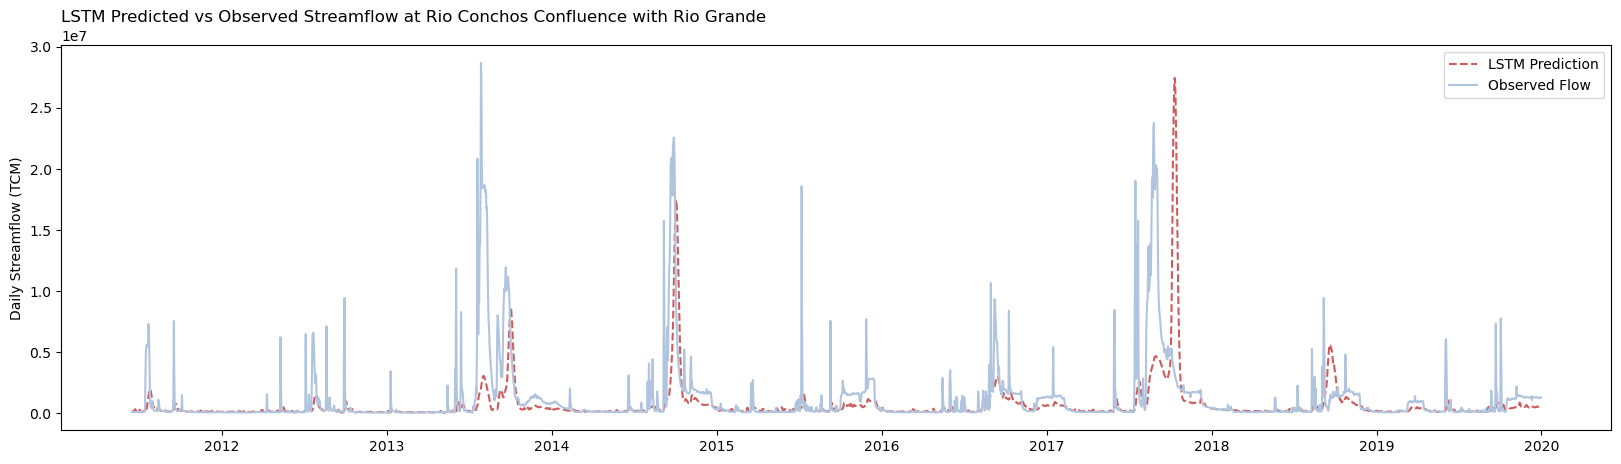

In [10]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(dates_dict['test_dates'],denormalized_predictions,ls='--',c='indianred',label='LSTM Prediction')
ax.plot(dates_dict['test_dates'],denormalized_ytest,ls='-',c='lightsteelblue',label='Observed Flow')
ax.legend()
ax.set_title('LSTM Predicted vs Observed Streamflow at Rio Conchos Confluence with Rio Grande',loc='left')
ax.set_ylabel('Daily Streamflow (TCM)')

In [12]:
explainer = shap.DeepExplainer(model, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


AttributeError: in user code:

    File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 250, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 390, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefix before the lookup
    File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 682, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 689, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py", line 226, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer 'lstm_1' (type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer 'lstm_1' (type LSTM):
      • inputs=tf.Tensor(shape=(200, 365, 64), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None
